# Makemore (Part 2)
Now we are going to make a MLP (MultiLayer Perceptron) that takes more than one character to predict the next. The architecture will be based on the one in [this paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).  
Basically, it uses **embedding** to embed a big vector representing a word into a smaller one.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('/media/eric/D/datasets/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Now, one way to do a simple embedding is to create a **Look up Table**, that maps the 27 characters into vectors of 2 dimensions.

In [7]:
C = torch.randn((27, 2))
C[5]

tensor([-0.5658,  0.0851])

As seen in Part 1, indexing like this is like doing matrix multiplication with a one-hot vector, but faster:

In [8]:
F.one_hot(torch.tensor([5]), num_classes=27).float() @ C

tensor([[-0.5658,  0.0851]])

In [9]:
print(C[[5, 6, 7, 7, 7]]) # this also works
print(C[X].shape) # and this too

tensor([[-0.5658,  0.0851],
        [ 2.1693, -0.0268],
        [ 1.7355, -1.1009],
        [ 1.7355, -1.1009],
        [ 1.7355, -1.1009]])
torch.Size([32, 3, 2])


In [10]:
X[13, 2] # example 13, character 2

tensor(1)

In [11]:
C[X][13, 2] # embedding for that character

tensor([-0.5173,  2.0030])

In [12]:
C = torch.randn((27, 2))
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [13]:
W1 = torch.randn((6, 100)) # 3x2 = 6 
b1 = torch.randn(100)

Now we want to do `emb @ W1 + b1`, but `emb` is of shape `[32, 3, 2]`, and we need `[32, 6]`. There are several ways to do this:

In [14]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [15]:
torch.cat(torch.unbind(emb, dim=1), 1).shape

torch.Size([32, 6])

The best way is using `torch.view()`. It's very efficient because it doesn't modify the data. Actually, torch Tensors are stored in memory as a single row of numbers (we can see that with `mytensor.storage()`), and the shape is determined by other attributes of this tensor. So `torch.view()` doesn't change the data but these attributes.

In [16]:
emb.view(-1, 6).shape

torch.Size([32, 6])

In [17]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # carefull with how the sum with b1 is broadcasted
h.shape

torch.Size([32, 100])

In [18]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [19]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [20]:
counts = logits.exp()

In [21]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape, prob[0].sum()

(torch.Size([32, 27]), tensor(1.0000))

In [22]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(20.0379)

**SUMMARIZED:**

In [23]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [24]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [25]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [26]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# --- Before ---
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
# --- Now ---
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

`F.cross_entropy()` is better because:
1. Makes same operations, but uses "kernels" instead of creating new tensors in memory
2. Backpropagation is a more simplified formula than doing backpropagation of every step
3. It's "numerically well behavied", as before using `exp()` could create `inf` or very small numbers for extreme values for logits, while this other approach will handle this by substracting to the logits the maximum logit (or adding if it's negative).

Now we continue:

In [27]:
for p in parameters:
	p.requires_grad = True

In [28]:
for i in range(200):
	# forward pass
	emb = C[X] # (32, 3, 10)
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Y)
	if i % 10 == 0:
		print(loss.item())
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update
	for p in parameters:
		p.data += -0.1 * p.grad

17.76971435546875
3.985848903656006
1.7380965948104858
1.1367990970611572
0.7891992330551147
0.553256094455719
0.43213313817977905
0.38926514983177185
0.3655855357646942
0.34906232357025146
0.3354487717151642
0.32326310873031616
0.31282925605773926
0.3045872747898102
0.2982344627380371
0.29326295852661133
0.2892763018608093
0.2860059142112732
0.28327125310897827
0.2809479534626007


Altough the dataset we passed is very small (32) and we have a lot of parameters and it overfits, we don't get a loss of 0.0 because some inputs have multiple possible outputs.

## Training with the whole dataset in minibatches

In [29]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [30]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [31]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [32]:
sum(p.nelement() for p in parameters)

3481

In [33]:
for p in parameters:
	p.requires_grad = True

In [34]:
for i in range(300):
	# minibatch construct
	ix = torch.randint(0, X.shape[0], (32,))

	# forward pass
	emb = C[X[ix]] # (32, 3, 10)
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Y[ix])
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update
	for p in parameters:
		p.data += -0.1 * p.grad

print(loss.item())

2.8850111961364746


When we do minibatches it's much faster, but the quality of the gradient is lower (the direction we decrease is not the actual gradient direction), but it's good enough and approximate. So, it's better to have an approximate gradient and just make more steps, than evaluate the exact gradient and take fewer steps.  
Then we can evaluate the exact loss on the entire training set once at the end:

In [35]:
emb = C[X] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.9041, grad_fn=<NllLossBackward0>)

But, how do we know what **learning rate** we use?

In [36]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponents
lrs = 10 ** lre # learning rates
lrs# from 0.001 to 1

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [37]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
	p.requires_grad = True

In [38]:
lri = []
lri2 = []
lossi = []

for i in range(1000):
	# minibatch construct
	ix = torch.randint(0, X.shape[0], (32,))

	# forward pass
	emb = C[X[ix]] # (32, 3, 10)
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Y[ix])
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update
	lr = lrs[i]
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	lri.append(lre[i])
	lri2.append(lr)
	# stepi.append(i)
	lossi.append(loss.item())

print(loss.item())

8.121506690979004


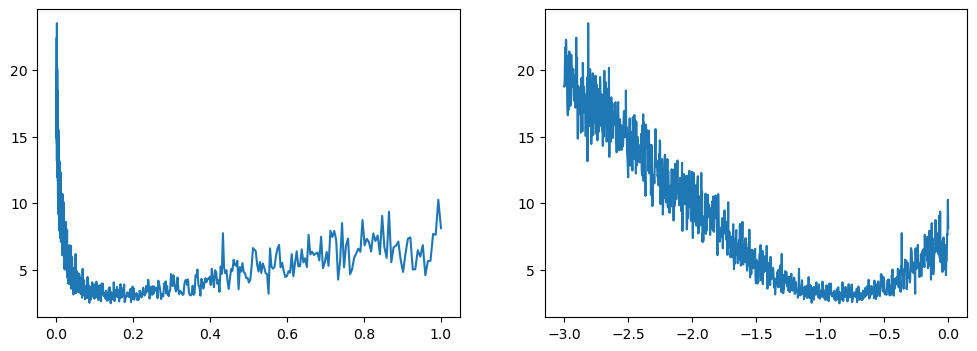

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(lri2, lossi)
plt.subplot(1, 2, 2)
plt.plot(lri, lossi)

So, `-1` was a good learning rate exponent, so `lr = 0.1`. Also, we can do a learning rate decay, where after some iterations, we decrease it by a factor of 10:

In [40]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
	p.requires_grad = True

In [41]:
for i in range(50000):
	# minibatch construct
	ix = torch.randint(0, X.shape[0], (32,))

	# forward pass
	emb = C[X[ix]] # (32, 3, 10)
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Y[ix])
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update
	lr = 0.1
	if i >= 30000:
		lr = 0.01
	for p in parameters:
		p.data += -lr * p.grad

print(loss.item())

2.224853754043579


## Splitting into train, dev/validation and test set

In [42]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [43]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
	p.requires_grad = True

In [44]:
for i in range(50000):
	# minibatch construct
	ix = torch.randint(0, Xtr.shape[0], (32,))

	# forward pass
	emb = C[Xtr[ix]] # (32, 3, 10)
	h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Ytr[ix])
	
	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()
	
	# update
	lr = 0.1
	if i >= 30000:
		lr = 0.01
	for p in parameters:
		p.data += -lr * p.grad

print(loss.item())

2.4889087677001953


In [46]:
emb = C[Xtr] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3223, grad_fn=<NllLossBackward0>)

In [45]:
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3218, grad_fn=<NllLossBackward0>)

The training and validation loss are almost equal. **That typically means that our network is too small and we expect to make performance improvements by scaling up the size of this network.**  
We increase from 100 --> 300 neurons. So we increase from ~3000 --> ~10000 parameters.

In [47]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
	p.requires_grad = True

In [48]:
sum(p.nelement() for p in parameters)

10281

In [52]:
lri = []
lossi = []
stepi = []

for i in range(30000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

2.459496021270752


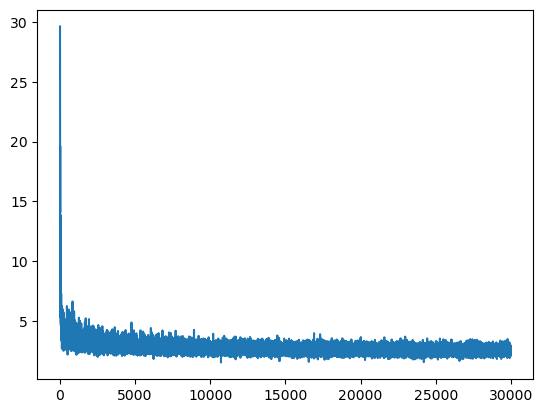

In [53]:
plt.plot(stepi, lossi)

This noise is caused because we are training by minibatches.

In [54]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5494, grad_fn=<NllLossBackward0>)

We continue training, with some learning rate decay...

In [55]:
for i in range(60000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.01 if i < 30000 else 0.005
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

2.222153425216675


In [56]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3577, grad_fn=<NllLossBackward0>)

In [57]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3625, grad_fn=<NllLossBackward0>)

In [58]:
for i in range(60000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.005
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.item())

print(loss.item())

2.40765380859375


In [59]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3063, grad_fn=<NllLossBackward0>)

In [60]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3185, grad_fn=<NllLossBackward0>)

Despite increasing the model size, we don't see much improvement. This could be becasue the bottleneck is actually in the embeddings. Currently we have embeddings of 2 dimensions:

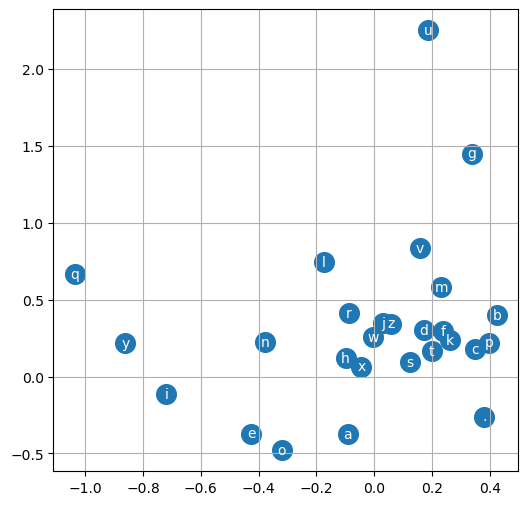

In [63]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Let's increase the dimensions of the embeddings to 10 (and also we decrease a bit the number of neurons to 200):

In [64]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
	p.requires_grad = True

In [65]:
sum(p.nelement() for p in parameters)

11897

In [66]:
lri = []
lossi = []
stepi = []

for i in range(60000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.0205764770507812


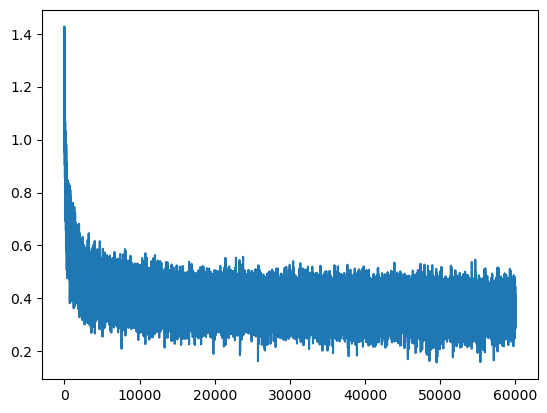

In [67]:
plt.plot(stepi, lossi)

In [68]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3647, grad_fn=<NllLossBackward0>)

In [69]:
for i in range(40000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.0689268112182617


In [70]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1581, grad_fn=<NllLossBackward0>)

In [71]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1859, grad_fn=<NllLossBackward0>)

As wee see the training and validation loss are slightly more different this time, so the number of parameters is starting to get good enough.

In [72]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d) The first dimension was the size of the training set,
      # but now we working with a single example at a time
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1) # exp and normalize to sum to 1
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
see.
mad.
rylle.
eversleygraege.
zeredielin.
shy.
jen.
eden.
estanaraylyn.
malkelin.
shub.
rishiriel.
jenie.
jelipanthoori.
brey.
dariyah.
faehs.
kayshia.
